In [23]:
# %load_ext nb_black

import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter

warnings.filterwarnings("ignore")
randomseed = 7

In [24]:
data1 = pd.read_csv("NextYearData_actualData_train.txt")
data2 = pd.read_csv("ThisYearData_actualData_train.txt")
data3 = pd.read_csv("ThisYearData_actualData_test.txt")

data4 = pd.read_csv("NextYearData_actualData_test.txt")

data5 = pd.read_csv("Predicted_NextYearData.txt")

data = pd.concat([data1, data2, data3])

print(data.shape)
data.head()

(1780, 18)


,Unnamed: 0,FIELD_1,FIELD_2,L100700,S000300,L101700,L103300,L103100,L190900,L504700,L190300,L103000,FIELD_15,FIELD_38,FIELD_33,SEX,AGE,CLASS
0,0,123111,20140729,4.2,18.9,13.0,2.3,75.0,13.0,0.86,4.45,64.0,0.0,2.0,1.0,1.0,25.0,1
1,1,247895,20150729,6.1,23.5,26.0,4.6,43.0,12.7,0.60,4.50,114.0,0.0,1.0,3.0,0.0,29.0,1
2,2,273354,20141111,4.1,18.6,29.0,2.1,89.0,12.9,1.00,4.51,76.0,0.0,3.0,3.0,1.0,29.0,1
3,3,273354,20151215,4.0,19.7,43.0,1.9,105.0,13.6,0.70,4.48,34.0,0.0,5.0,3.0,1.0,30.0,1
4,4,299264,20150729,6.9,29.4,87.0,6.1,35.0,13.1,2.90,5.31,242.0,0.0,1.0,1.0,0.0,30.0,1


In [25]:
print(data.groupby(by='CLASS').size())

maindata=data.copy()

class0=maindata[maindata.CLASS==0]
class1=maindata[maindata.CLASS==1]

class0=class0.sample(class1.shape[0],random_state=42)

data=pd.concat([class1,class0])

print(data.shape)


CLASS
0    1181
1     599
dtype: int64
(1198, 18)


In [26]:
data=data[['L100700','S000300','L101700','L103300','L103100','L190900','L504700','L190300','L103000','FIELD_15','FIELD_38','FIELD_33','SEX','AGE','CLASS']]
xtrain, xtest, ytrain, ytest = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], random_state=42, test_size=0.3)

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=1000,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features=8,
)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.6361111111111111


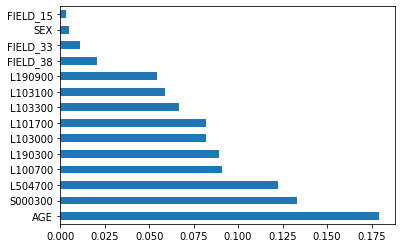

Index(['AGE', 'S000300', 'L504700', 'L100700', 'L190300', 'L103000', 'L101700',
       'L103300', 'L103100', 'L190900', 'FIELD_38', 'FIELD_33', 'SEX',
       'FIELD_15'],
      dtype='object')


In [28]:
ypred = rf.predict(xtest)

score = rf.score(xtest, ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=xtest.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

In [29]:
print("Accuracy on training set: {:.3f}".format(rf.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest, ytest)))

confmatrx = pd.DataFrame(m.confusion_matrix(ytest, ypred))
confmatrx.head()

Accuracy on training set: 0.860
Accuracy on test set: 0.636


,0,1
0,120,56
1,75,109


In [30]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65       176
           1       0.66      0.59      0.62       184

    accuracy                           0.64       360
   macro avg       0.64      0.64      0.64       360
weighted avg       0.64      0.64      0.64       360



In [31]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

xgb_model.fit(xtrain, ytrain)

y_pred = xgb_model.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.625


,0,1
0,114,62
1,73,111


In [32]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63       176
           1       0.64      0.60      0.62       184

    accuracy                           0.62       360
   macro avg       0.63      0.63      0.62       360
weighted avg       0.63      0.62      0.62       360



In [33]:
data4=data4[['L100700','S000300','L101700','L103300','L103100','L190900','L504700','L190300','L103100','FIELD_15','FIELD_38',
             'FIELD_33','SEX','AGE','CLASS']]

pred4 = rf.predict((data4.iloc[:, :-1]))

print(m.accuracy_score(data4.iloc[:, -1], pred4))

confmatrx = pd.DataFrame(m.confusion_matrix(data4.iloc[:, -1], pred4))
confmatrx

0.63


,0,1
0,34,16
1,21,29


In [34]:
print(classification_report(data4.iloc[:, -1], pred4))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65        50
           1       0.64      0.58      0.61        50

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.63      0.63      0.63       100



In [36]:
# =====================================
# =====================================
# =====================================
# =====================================

data5=data5[['P_L100700','P_S000300','P_L101700','P_L103300','P_L103100','P_L190900','P_L504700','P_L190300','P_L103000'
             ,'P_FIELD_15','P_FIELD_38','P_FIELD_33','P_SEX','P_AGE','CLASS']]
data5.columns=data4.columns
pred5 = rf.predict((data5.iloc[:, :-1]))



print(m.accuracy_score(data5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(data5.iloc[:, -1], pred5))
confmatrx

KeyError: "['P_FIELD_33', 'P_L103000', 'P_L190900', 'P_L103300', 'P_SEX', 'P_S000300', 'P_FIELD_15', 'P_L101700', 'P_L100700', 'P_AGE', 'P_FIELD_38', 'P_L504700', 'P_L190300', 'P_L103100'] not in index"

In [37]:
print(classification_report(data5.iloc[:, -1], pred5))

              precision    recall  f1-score   support

           0       0.55      0.66      0.60        50
           1       0.57      0.46      0.51        50

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100



In [ ]:
# ========================================================

In [ ]:
print(xtrain.shape)

In [ ]:
print(xtest.shape)

In [ ]:
data5.shape

In [ ]:
data.to_csv('_train.txt',sep=',')

In [ ]:
data4.to_csv('_test.txt',sep=',')

In [ ]:
data5.to_csv('_PredictedNextYearTest.txt',sep=',')

In [ ]:
data4.head()